In [7]:
import shutil

import matplotlib.pyplot as plt
import pandas as pd

import evalml

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-10-09 20:07:34.815200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 20:07:35.392750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [8]:
zero_values_percentage_cutoff = 0.5 # no more than x% of data can be zeros
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-10-09 20:07:39.195718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 20:07:39.213984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use avai2023-10-09 20:07:39.213984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
lable CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 20:07:39.214483: I tensorflow/core/platform/cpu_featu

In [9]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## Features and targets

In [14]:

def create_flat_sequences(df, seq_length):
    # Solves the problem of representing sequences of taxa counts in 2d space
    # Using seq_length previous values for each column predict the next one
    
    # Example:
    
    # seq_length = 3
    
    # input data:
    #   one  two  three
    # 0    0   10     20
    # 1    1   11     21
    # 2    2   12     22
    # 3    3   13     23
    # 4    4   14     24
    # 5    5   15     25
    # 6    6   16     26
    # 7    7   17     27
    # 8    8   18     28
    # 9    9   19     29
    # 
    # feats_df.iloc[0]:
    #     0  1  2   3   4   5   6   7   8
    #     0  1  2  10  11  12  20  21  22
    #
    # targets_df.iloc[0]:
    #       one  two  three
    #        3   13     23
      
    
    df = df.reset_index(drop=True)
    
    feats_list = []
    targets = []
    for top_sample_idx in df.index[seq_length - 1: len(df) - 1]:
        feats_row = []
        for taxa_idx in df.columns:
            taxa_sequence = df.loc[top_sample_idx - seq_length + 1: top_sample_idx, taxa_idx]
            feats_row.append(taxa_sequence)
            
        target = df.loc[top_sample_idx + 1]
        targets.append(target)      
            
        feats_row = pd.concat(feats_row, ignore_index=True)
        feats_list.append(feats_row)
        
    feats_df = pd.concat(feats_list, axis=1).T
    targets_df = pd.concat(targets, axis=1).T
    
    return feats_df, targets_df
    

In [4]:
seq_length = 50
feats, targets = create_flat_sequences(df, seq_length=seq_length)

NameError: name 'df' is not defined

In [8]:
feats_train, feats_test, targets_train, targets_test = evalml.preprocessing.split_data(feats, targets, problem_type="regression", test_size=0.1)
feats_train, feats_val, targets_train, targets_val = evalml.preprocessing.split_data(feats_train, targets_train, problem_type="regression", test_size=0.1)

In [9]:
#cutoff = 436
#
#feats_train = feats[:cutoff]
#targets_train = targets[:cutoff]
#
#feats_train, feats_val, targets_train, targets_val = evalml.preprocessing.split_data(feats_train, targets_train, problem_type="regression", test_size=0.1)
#
#feats_test = feats[cutoff:]
#targets_test = targets[cutoff:]

In [10]:
#print(f"Length of data: {len(df)}")
#print(f"Total sequences: {len(feats)}")
#print(f"Train sequences: {len(feats_train)}")
#print(f"Test sequences: {len(feats_test)}")

## The model

In [11]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=10, 
                         max_leaves=100,
                         max_depth=100, 
                         early_stopping_rounds=3, 
                         n_jobs=50)

In [12]:
model.fit(feats_train, targets_train, eval_set=[(feats_val, targets_val)], verbose=True)

[0]	validation_0-rmse:0.13352
[1]	validation_0-rmse:0.11000
[2]	validation_0-rmse:0.09541
[3]	validation_0-rmse:0.08753
[4]	validation_0-rmse:0.08320
[5]	validation_0-rmse:0.08102
[6]	validation_0-rmse:0.07991
[7]	validation_0-rmse:0.07939
[8]	validation_0-rmse:0.07920
[9]	validation_0-rmse:0.07917


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=3,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=100,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=50,
             num_parallel_tree=None, random_state=None, ...)

## Validation

In [18]:
test_df = pd.DataFrame(targets_test)
test_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
435,0.000000,0.093404,0.160920,0.026316,0.023843,0.143345,0.502970,0.072727,0.473757,0.222222,...,0.314845,0.076923,0.000241,0.244898,0.096647,0.491541,0.047244,0.431141,0.214952,0.086379
340,0.000304,0.000256,0.218391,0.025359,0.019635,0.037543,0.279208,0.400000,0.072547,0.504630,...,0.200653,0.070513,0.029282,0.448980,0.002345,0.325592,0.153543,0.149668,0.143248,0.225914
134,0.379331,0.000664,0.080460,0.062201,0.000000,0.061433,0.000000,0.563636,0.000000,0.449074,...,0.069331,0.115385,0.272570,0.387755,0.000112,0.011996,0.106299,0.025951,0.071839,0.601329
90,0.006079,0.000034,0.034483,0.000000,0.008415,0.081911,0.025743,0.090909,0.067051,0.055556,...,0.150082,0.006410,0.000072,0.061224,0.000000,0.065672,0.043307,0.056005,0.036893,0.508306
378,0.002432,0.000017,0.367816,0.017225,0.000000,0.133106,0.000000,0.545455,0.305853,0.305556,...,0.230832,0.108974,0.018638,0.346939,0.000424,0.020763,0.114173,0.073627,0.802295,0.086379
21,0.148632,0.000136,0.149425,0.002392,0.172511,0.409556,0.003960,0.454545,0.268755,0.574074,...,0.358891,0.269231,0.003733,0.571429,0.029617,0.018610,0.153543,0.040435,0.001539,0.604651
240,0.253799,0.000051,0.000000,0.100000,0.117812,0.000000,0.000000,0.381818,0.000000,0.449074,...,0.000000,0.000000,0.005057,0.795918,0.555650,0.000154,0.000000,0.000241,0.000136,0.169435
278,0.161398,0.020493,0.172414,0.020096,0.006311,0.078498,0.114851,0.054545,0.098379,0.148148,...,0.296900,0.038462,0.000024,0.122449,0.000268,0.108274,0.031496,0.212915,0.201824,0.036545
253,0.230699,0.000068,0.068966,0.004306,0.110098,0.501706,0.005941,0.436364,0.044243,0.643519,...,0.311582,0.826923,0.000048,0.326531,0.000089,0.019994,0.110236,0.084369,0.002739,0.495017
231,0.001216,0.005536,0.126437,0.024402,0.007714,0.187713,0.005941,0.381818,0.000000,0.476852,...,0.001631,0.102564,0.295567,0.632653,0.000022,0.030145,0.196850,0.031744,0.062310,0.285714


In [19]:
pred_df = pd.DataFrame(model.predict(feats_test))
pred_df.columns = test_df.columns
pred_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.086542,0.065042,0.150749,0.025356,0.029413,0.106347,0.429494,0.075781,0.552832,0.201787,...,0.241121,0.071673,0.004719,0.231858,0.090405,0.349372,0.061543,0.321488,0.201366,0.051234
1,0.004381,0.004398,0.207315,0.036572,0.052018,0.064894,0.330640,0.487488,0.059534,0.743699,...,0.224331,0.189155,0.021130,0.422963,0.018627,0.376085,0.192784,0.181918,0.084638,0.237003
2,0.312834,0.004398,0.081413,0.047327,0.004951,0.064661,0.006212,0.513512,0.004204,0.389124,...,0.088159,0.091188,0.160701,0.298761,0.004339,0.008707,0.089249,0.029026,0.074148,0.571477
3,0.010302,0.004398,0.046369,0.006890,0.024465,0.091294,0.071554,0.136280,0.127577,0.095997,...,0.144039,0.016225,0.004587,0.121089,0.004275,0.122665,0.040125,0.117407,0.060904,0.323401
4,0.004381,0.004398,0.329702,0.025023,0.006687,0.132472,0.012694,0.278808,0.243286,0.245143,...,0.203132,0.131098,0.037314,0.330723,0.004339,0.027251,0.114726,0.074832,0.712453,0.115077
5,0.070610,0.009082,0.208216,0.006468,0.108756,0.615659,0.007829,0.390634,0.038658,0.447667,...,0.262521,0.269839,0.005149,0.538473,0.021333,0.015152,0.110393,0.049340,0.004591,0.468463
6,0.200503,0.004398,0.004494,0.086580,0.167980,0.005765,0.006675,0.370678,0.009293,0.364763,...,0.042024,0.006075,0.007632,0.495272,0.385990,0.005382,0.006646,0.004668,0.004591,0.120646
7,0.212941,0.021381,0.201949,0.022693,0.031650,0.078700,0.116221,0.058038,0.101847,0.177815,...,0.439767,0.041150,0.006223,0.173545,0.004275,0.150305,0.043294,0.283638,0.179375,0.061417
8,0.250870,0.004398,0.104680,0.012886,0.110245,0.544200,0.008219,0.453852,0.019360,0.654538,...,0.468479,0.621886,0.005073,0.263766,0.004463,0.039878,0.167397,0.090948,0.009157,0.410042
9,0.036150,0.004398,0.101763,0.027085,0.017898,0.049625,0.074433,0.335039,0.016133,0.440739,...,0.076431,0.063445,0.281897,0.551703,0.004339,0.180562,0.032475,0.118336,0.168965,0.340773


In [21]:
errors_df = calculate_percentage_errors(pred_df, test_df)
errors_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.612933,0.765196,0.309247,0.747690,0.538586,0.748482,0.440468,0.364173,0.990896,0.304029,...,0.914153,0.354146,0.651819,0.261221,0.807289,0.290505,0.451938,0.322115,0.373202,0.401976
std,0.329241,0.314984,0.301867,1.713286,0.494292,2.273665,0.355853,0.376229,2.401151,0.317301,...,2.688868,0.301392,0.428271,0.238097,0.826292,0.243347,0.745539,0.368747,0.309410,0.400471
min,0.047293,0.020342,0.006986,0.009408,0.001328,0.001653,0.010529,0.011531,0.006735,0.016190,...,0.018927,0.001458,0.021995,0.000592,0.026312,0.020056,0.004819,0.013755,0.027805,0.005864
25%,0.284724,0.524034,0.094845,0.172726,0.176970,0.090430,0.141380,0.067841,0.215601,0.092021,...,0.105693,0.101499,0.212543,0.066809,0.336368,0.120848,0.181298,0.110973,0.111395,0.122932
50%,0.632260,0.941903,0.205097,0.306611,0.431987,0.275364,0.351611,0.250169,0.474423,0.217034,...,0.228467,0.279495,0.804537,0.202144,0.911791,0.262648,0.253429,0.247165,0.274434,0.255749
75%,0.930624,0.985763,0.450542,0.764530,0.854941,0.738962,0.713899,0.488924,1.000000,0.331679,...,0.476984,0.548456,0.984452,0.350628,0.988938,0.359220,0.428442,0.412185,0.633041,0.575285
max,1.104987,1.000000,1.000000,11.609587,2.731558,15.642193,1.389596,1.533018,15.993582,1.362087,...,17.043344,1.000000,1.855692,1.000000,5.704898,1.000000,5.061683,2.162841,0.991010,1.959203


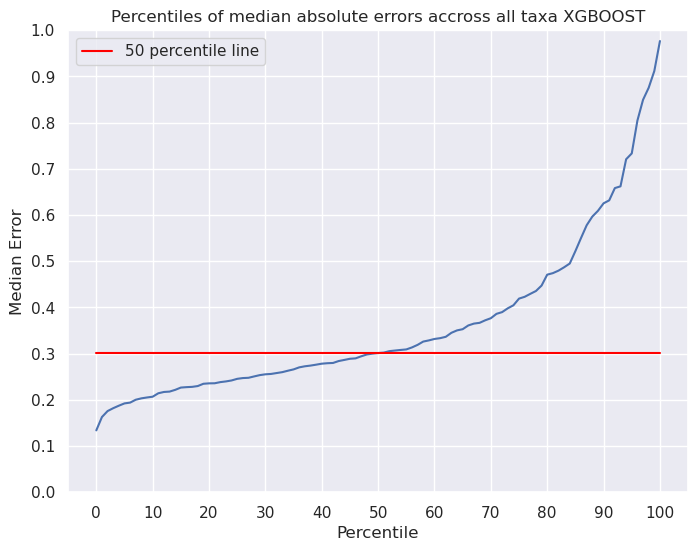

In [25]:
percentile_graph(errors_df, "accross all taxa XGBOOST", y_top_lim=1)